In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageFilter, ImageChops
PIL.Image.MAX_IMAGE_PIXELS = None
import cv2
import glob
from skimage import filters, measure
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from scipy.signal import convolve2d
from scipy.spatial import KDTree
import seaborn as sns
import pickle
import librosa as lb
import time
import cProfile
import os
import os.path
import pyximport; pyximport.install()
import multiprocessing
import math
import time

### Configuration Parameters

In [217]:
imagefile = '/home/mshan/ttemp/data/png/p20/p20-3.png'

In [218]:
### system parameters ###

# Pre-processing
thumbnailW = 100  # bkgd lighting
thumbnailH = 100
thumbnailFilterSize = 5
estLineSep_NumCols = 3
estLineSep_LowerRange = 13
estLineSep_UpperRange = 27
estLineSep_Delta = 1
targetLineSep = 10.0

# Staff Line Features
morphFilterHorizLineSize = 41
notebarFiltLen = 3
notebarRemoval = 0.9
calcStaveFeatureMap_NumCols = 10
calcStaveFeatureMap_LowerRange = 8.5
calcStaveFeatureMap_UpperRange = 11.75
calcStaveFeatureMap_Delta = 0.25

# Notehead Detection
morphFilterCircleSizeReduce = 5
morphFilterCircleSizeExpand = 5
#morphFilterCircleSize = 5
notedetect_minarea = 50
notedetect_maxarea = 200
noteTemplateSize = 21
notedetect_tol_ratio = .4
chordBlock_minH = 1.25
chordBlock_maxH = 4.25
chordBlock_minW = .8
chordBlock_maxW = 2.25
chordBlock_minArea = 1.8
chordBlock_maxArea = 4.5
chordBlock_minNotes = 2
chordBlock_maxNotes = 4

# Staffline Detection
maxDeltaRowInitial = 50
minNumStaves = 8
maxNumStaves = 16
minStaveSeparation = 6 * targetLineSep
maxDeltaRowRefined = 15

# Group Staves
morphFilterVertLineLength = 101
morphFilterVertLineWidth = 7
maxBarlineWidth = 15
#maxBarlineLenFactor = .25

# Generate Bootleg Score
bootlegRepeatNotes = 1
bootlegFiller = 0

# Alignment
dtw_steps = [1,1,1,2,2,1] # dtw
dtw_weights = [1,1,2]

##########################

### Pre-processing

Pre-processing consists of two steps:
- background subtraction to reduce effect of lighting conditions
- interline normalization

In [219]:
pim1 = Image.open(imagefile).convert('L') # pim indicates PIL image object, im indicates raw pixel values
#pim1.thumbnail([resizeW, resizeH]) # modifies in place
#pim1

In [220]:
def removeBkgdLighting(pimg, filtsz=5, thumbnailW = 100, thumbnailH = 100):
    tinyimg = pimg.copy()
    tinyimg.thumbnail([thumbnailW, thumbnailH]) # resize to speed up
    shadows = tinyimg.filter(ImageFilter.GaussianBlur(filtsz)).resize(pimg.size)
    result = ImageChops.invert(ImageChops.subtract(shadows, pimg))
    return result

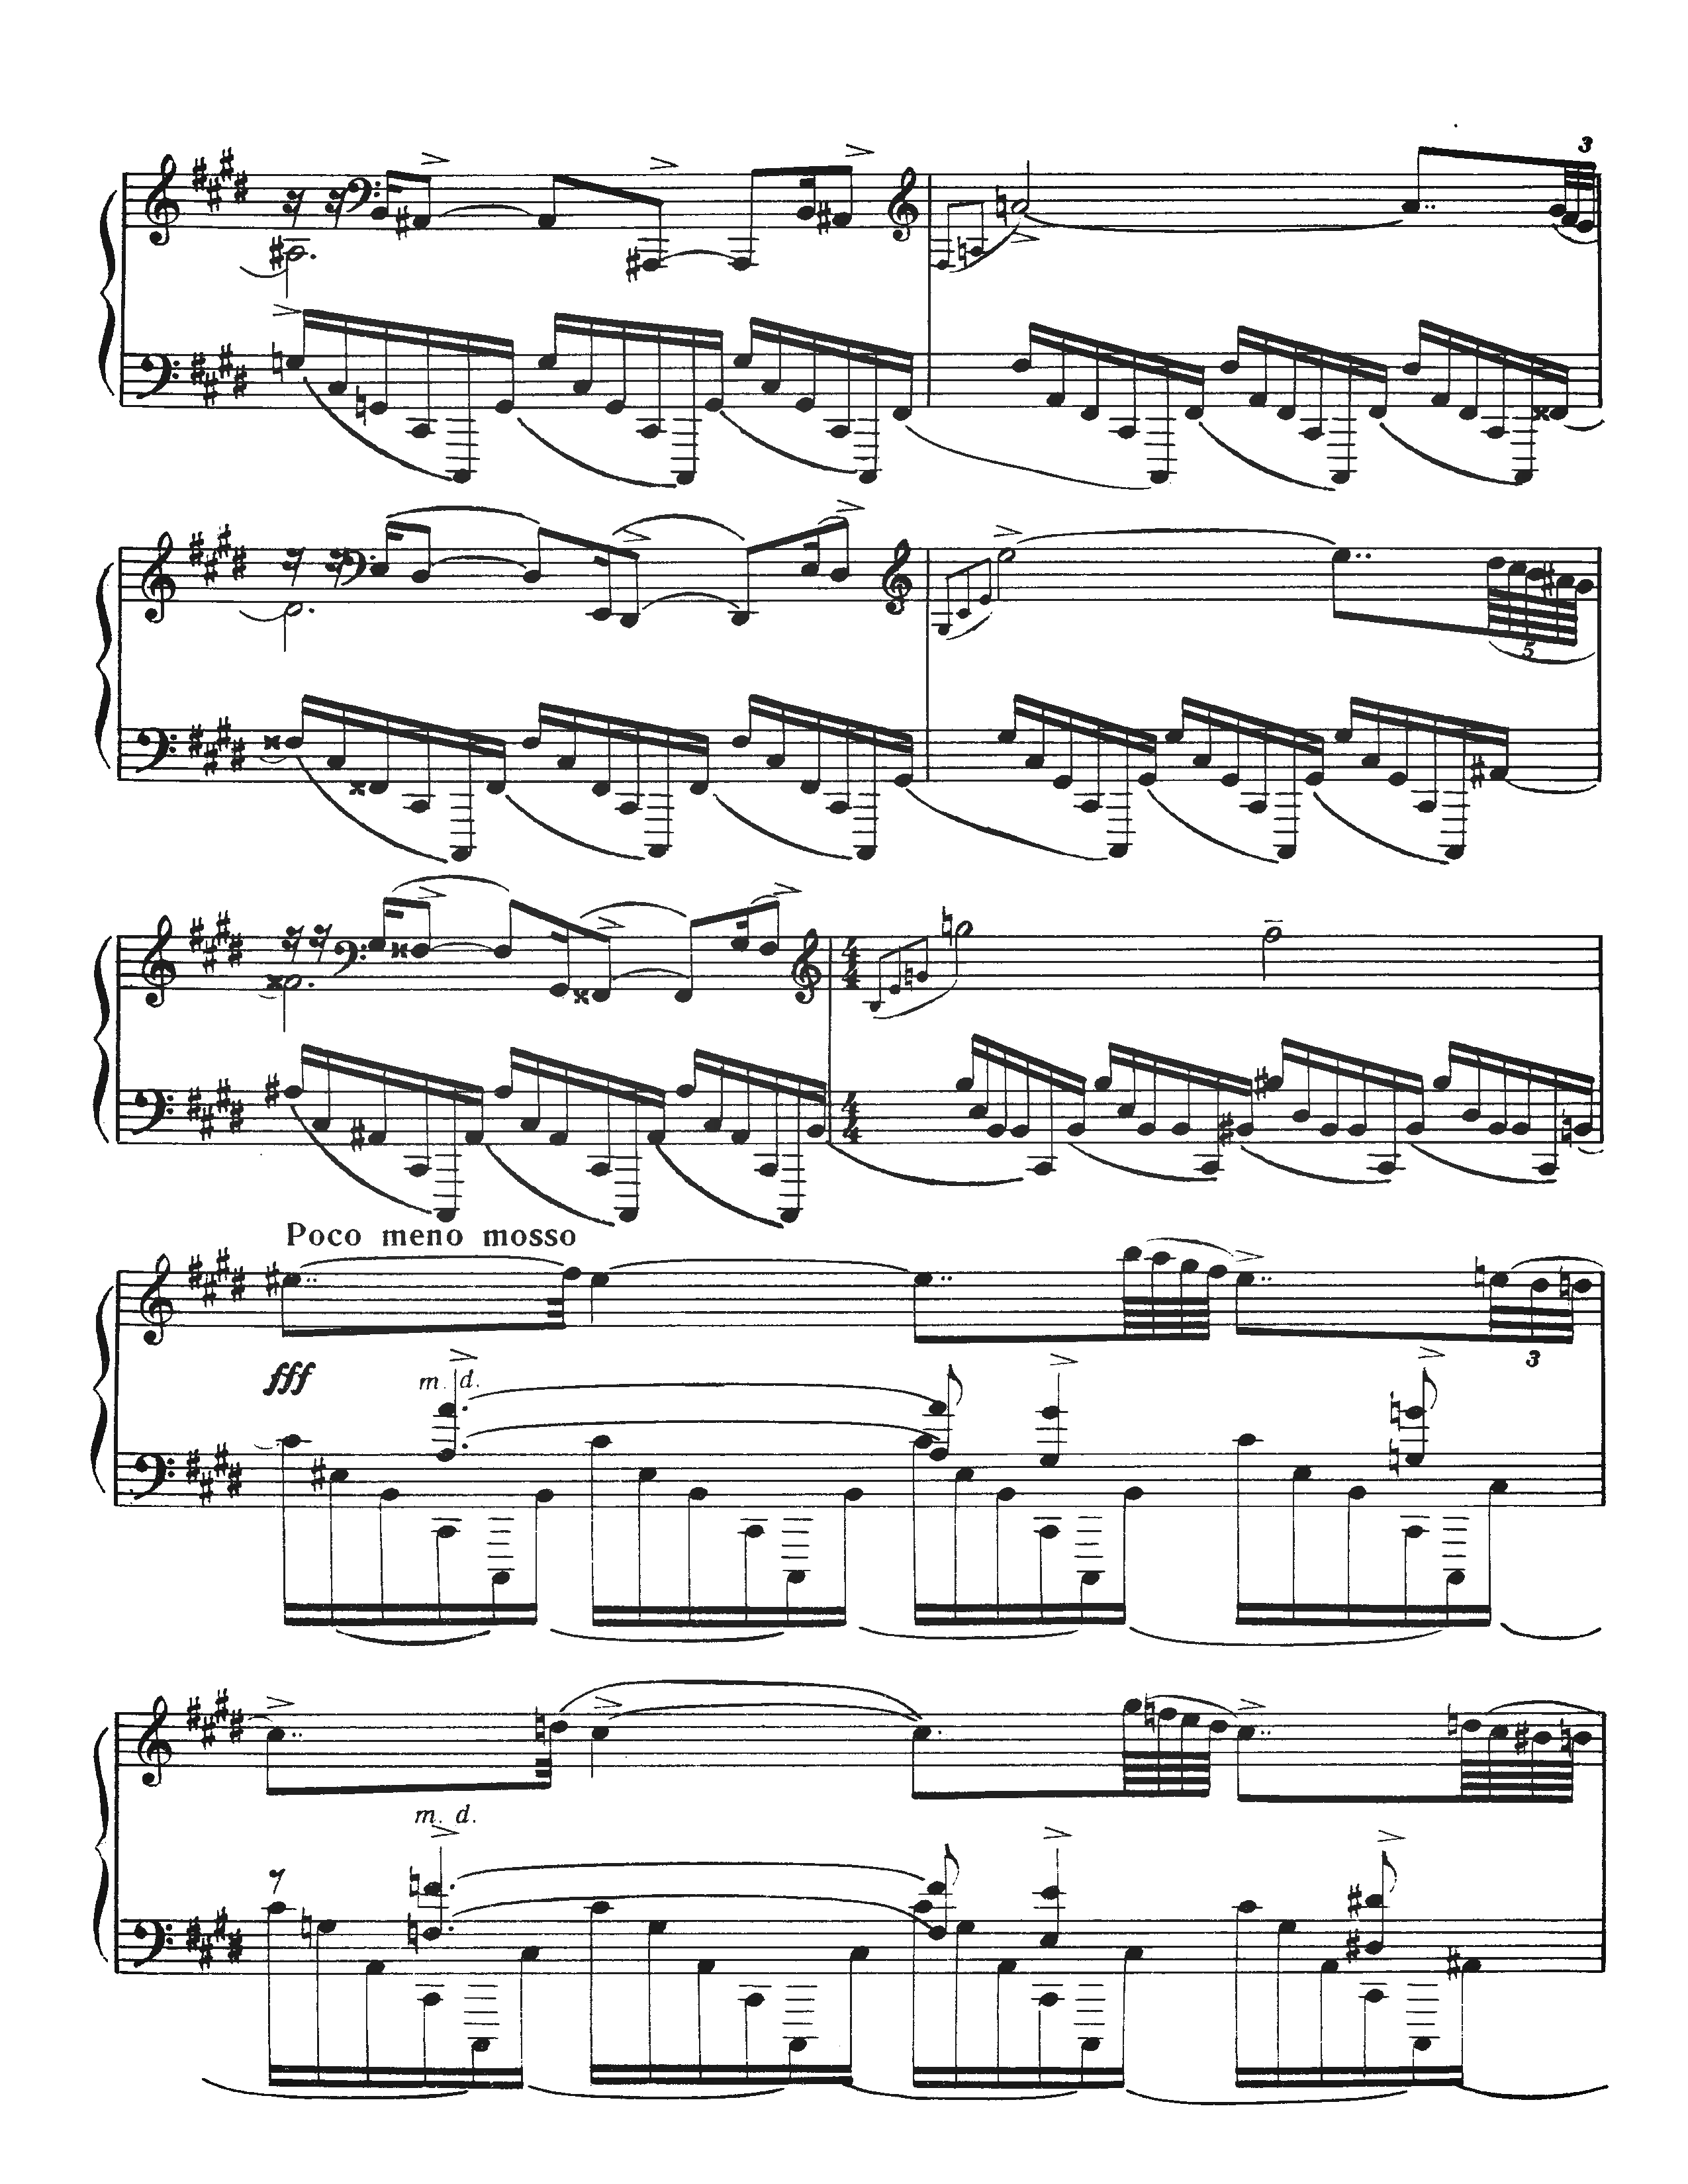

In [221]:
pim2 = removeBkgdLighting(pim1, thumbnailFilterSize, thumbnailW, thumbnailH)
pim2

In [222]:
def getPenalizedCombFilter(linesep):
    filt = np.zeros(int(np.round(linesep * 5)))
    
    # positive spikes
    for i in range(5):
        offset = int(np.round(.5*linesep + i*linesep))
        filt[offset-1:offset+2] = 1.0
    
    # negative spikes
    for i in range(6):
        center = int(np.round(i*linesep))
        startIdx = max(center - 1, 0)
        endIdx = min(center + 2, len(filt))
        filt[startIdx:endIdx] = -1.0
        
    return filt

In [223]:
def estimateLineSep(pim, ncols, lrange, urange, delta):
    
    # break image into columns, calculate row medians for inner columns (exclude outermost columns)
    img = 255 - np.array(pim)
    imgHeight, imgWidth = img.shape
    rowMedians = np.zeros((imgHeight, ncols))
    colWidth = imgWidth // (ncols + 2)
    for i in range(ncols):
        rowMedians[:,i] = np.median(img[:,(i+1)*colWidth:(i+2)*colWidth], axis=1)
    
    # apply comb filters
    lineseps = np.arange(lrange, urange, delta)
    responses = np.zeros((len(lineseps), imgHeight, ncols))
    for i, linesep in enumerate(lineseps):
        filt = getPenalizedCombFilter(linesep).reshape((-1,1))
        responses[i,:,:] = convolve2d(rowMedians, filt, mode = 'same')
    
    # find comb filter with strongest response
    scores = np.sum(np.max(responses, axis=1), axis=1)
    bestIdx = np.argmax(scores)
    estLineSep = lineseps[bestIdx]
    
    return estLineSep, scores

In [224]:
linesep, scores = estimateLineSep(pim2, estLineSep_NumCols, estLineSep_LowerRange, estLineSep_UpperRange, estLineSep_Delta)
linesep

20

In [225]:
def calcResizedDimensions(pim, estimatedLineSep, desiredLineSep):
    curH, curW = pim.height, pim.width
    scale_factor = 1.0 * desiredLineSep / estimatedLineSep
    targetH = int(curH * scale_factor)
    targetW = int(curW * scale_factor)    
    return targetH, targetW

In [226]:
targetH, targetW = calcResizedDimensions(pim2, linesep, targetLineSep)
pim2 = pim2.resize((targetW, targetH))
targetH, targetW, pim1.height, pim1.width

(1650, 1275, 3300, 2550)

### Staff Line Features

In [227]:
def getNormImage(img):
    X = 1 - np.array(img) / 255.0
    return X

In [228]:
def showGrayscaleImage(X, sz = (10,10), maxval = 1, inverted = True):
    # by default assumes X is a normalized image between 0 (white) and 1 (black)
    plt.figure(figsize = sz)
    if inverted:
        plt.imshow(maxval-X, cmap='gray')
    else:
        plt.imshow(X, cmap='gray')

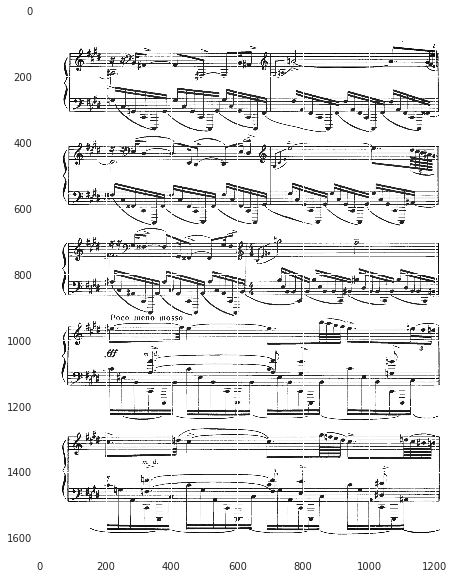

In [229]:
X2 = getNormImage(pim2)
showGrayscaleImage(X2)

In [230]:
def morphFilterRectangle(arr, kernel_height, kernel_width):
    kernel = np.ones((kernel_height, kernel_width),np.uint8)
    result = cv2.erode(arr, kernel, iterations = 1)
    result = cv2.dilate(result, kernel, iterations = 1)
    return result

In [231]:
def isolateStaffLines(arr, kernel_len, notebarfilt_len, notebar_removal):
    lines = morphFilterRectangle(arr, 1, kernel_len) # isolate horizontal lines
    notebarsOnly = morphFilterRectangle(lines, notebarfilt_len, 1) # isolate thick notebars
    result = np.clip(lines - notebar_removal*notebarsOnly, 0, None) # subtract out notebars
    return result

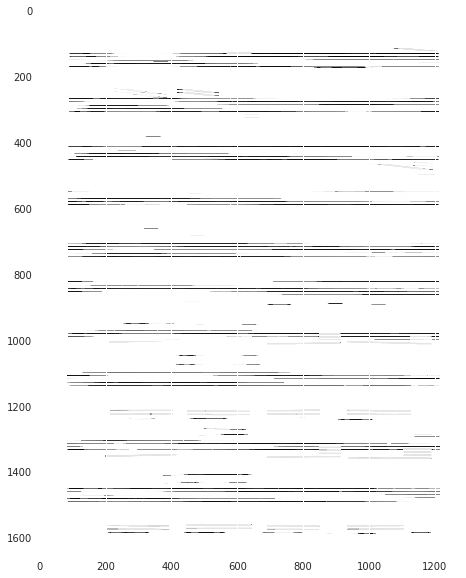

In [232]:
hlines = isolateStaffLines(X2, morphFilterHorizLineSize, notebarFiltLen, notebarRemoval)
showGrayscaleImage(hlines)

In [233]:
def getCombFilter(lineSep):
    # generate comb filter of specified length
    # e.g. if length is 44, then spikes at indices 0, 11, 22, 33, 44
    # e.g. if length is 43, then spikes at 0 [1.0], 10 [.25], 11 [.75], 21 [.5], 22 [.5], 32 [.75], 33 [.25], 43 [1.0]
    stavelen = int(np.ceil(4 * lineSep)) + 1
    combfilt = np.zeros(stavelen)
    for i in range(5):
        idx = i * lineSep
        idx_below = int(idx)
        idx_above = idx_below + 1
        remainder = idx - idx_below
        combfilt[idx_below] = 1 - remainder
        if idx_above < stavelen:
            combfilt[idx_above] = remainder
    return combfilt, stavelen

In [234]:
def computeStaveFeatureMap(img, ncols, lrange, urange, delta):
    
    # break image into columns, calculate row medians
    imgHeight, imgWidth = img.shape
    rowSums = np.zeros((imgHeight, ncols))
    colWidth = int(np.ceil(imgWidth/ncols))
    for i in range(ncols):
        startCol = i * colWidth
        endCol = min((i+1)*colWidth, imgWidth)
        rowSums[:,i] = np.sum(img[:,startCol:endCol], axis=1)
    
    # apply comb filters
    lineseps = np.arange(lrange, urange, delta)
    maxFiltSize = int(np.ceil(4 * lineseps[-1])) + 1
    featmap = np.zeros((len(lineseps), imgHeight - maxFiltSize + 1, ncols))
    stavelens = np.zeros(len(lineseps), dtype=np.int)
    for i, linesep in enumerate(lineseps):
        filt, stavelen = getCombFilter(linesep)
        padded = np.zeros((maxFiltSize, 1))
        padded[0:len(filt),:] = filt.reshape((-1,1))
        featmap[i,:,:] = convolve2d(rowSums, np.flipud(np.fliplr(padded)), mode = 'valid')
        stavelens[i] = stavelen
        
    return featmap, stavelens, colWidth

In [235]:
featmap, stavelens, columnWidth = computeStaveFeatureMap(hlines, calcStaveFeatureMap_NumCols, calcStaveFeatureMap_LowerRange, calcStaveFeatureMap_UpperRange, calcStaveFeatureMap_Delta)

### Notehead Detection

In [236]:
def morphFilterCircle(pimg, sz_reduce = 5, sz_expand = 0):
    kernel_reduce = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (sz_reduce, sz_reduce))
    result = cv2.dilate(np.array(pimg), kernel_reduce, iterations = 1)
    if sz_expand > 0:
        kernel_expand = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (sz_expand, sz_expand))
        result = cv2.erode(result, kernel_expand, iterations = 1)
    return result

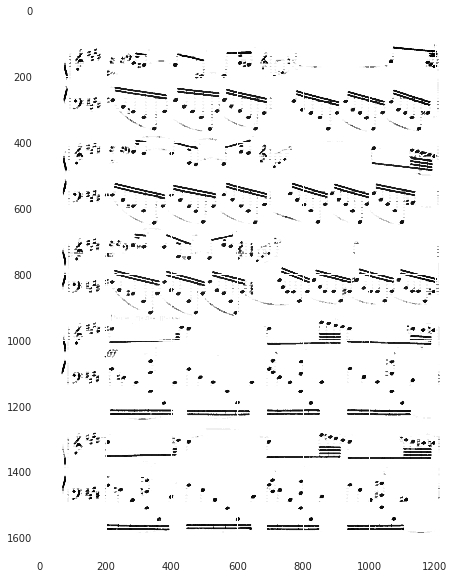

In [237]:
im3 = morphFilterCircle(pim2, morphFilterCircleSizeReduce, morphFilterCircleSizeExpand) # from here on use raw pixel values, not PIL image object
showGrayscaleImage(im3, maxval = 255, inverted = False)

In [238]:
def detectNoteheadBlobs(img, minarea, maxarea):
    
    # define blob detector
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    # params.minThreshold = 100;
    # params.maxThreshold = 200;

    # Filter by Area
    # params.filterByArea = True
    params.minArea = minarea
    params.maxArea = maxarea

    # Filter by Circularity
    # params.filterByCircularity = True
    # params.minCircularity = 0.1

    # Filter by Convexity
    # params.filterByConvexity = True
    # params.minConvexity = 0.87

    # Filter by Inertia
    # params.filterByInertia = True
    # params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)
    
    keypoints = detector.detect(img)
    im_with_keypoints = cv2.drawKeypoints(np.array(img), keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    return keypoints, im_with_keypoints

In [239]:
def showColorImage(X, sz = (10,10)):
    plt.figure(figsize = sz)
    plt.imshow(X)

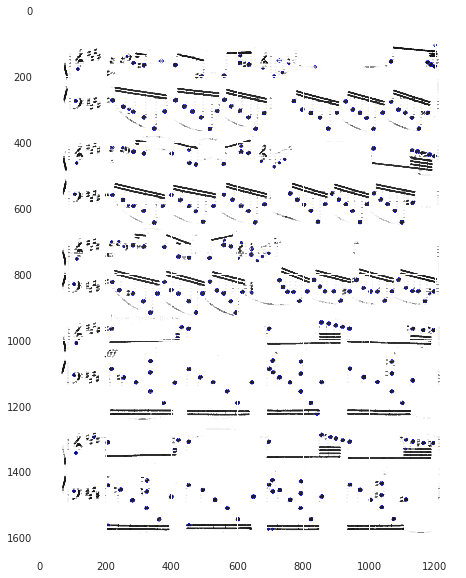

In [240]:
keypoints, im_with_keypoints = detectNoteheadBlobs(im3, notedetect_minarea, notedetect_maxarea)
showColorImage(im_with_keypoints)

In [241]:
def getNoteTemplate(arr, keypoints, sz = 21):
    template = np.zeros((sz,sz))
    L = (sz - 1)//2
    #crops = []
    numCrops = 0
    for k in keypoints:
        xloc = int(np.round(k.pt[0])) # col
        yloc = int(np.round(k.pt[1])) # row
        if xloc - L >= 0 and xloc + L + 1 <= arr.shape[1] and yloc - L >= 0 and yloc + L + 1 <= arr.shape[0]:
            crop = arr[yloc-L:yloc+L+1,xloc-L:xloc+L+1]
            #crops.append(crop)
            template += crop
            numCrops += 1
    if numCrops > 0:
        template = template / numCrops
    #template = template - np.mean(template.ravel()) # will be used as a filter, so make zero mean
    return template, numCrops

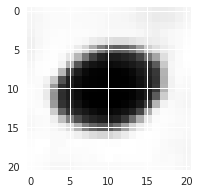

In [242]:
X3 = getNormImage(im3) # im indicates grayscale [0, 255], X indicates [0, 1] inverted grayscale
ntemplate, numCrops = getNoteTemplate(X3, keypoints, noteTemplateSize)
showGrayscaleImage(ntemplate, (3,3), maxval = 1, inverted = True)

In [243]:
def adaptiveNoteheadDetect(arr, template, noteTolRatio, chordBlockSpecs):
    #filtered = convolve2d(arr, np.flipud(np.fliplr(template)), mode='same', boundary='symm')
    binarized, _ = binarize_otsu(arr)
    labels = measure.label(binarized)
    notes = []
    if template.max() == 0: # no noteheads detected
        return notes, binarized
    templateSpecs = getNoteTemplateSpecs(template)
    for region in regionprops(labels):
        if isValidNotehead(region, noteTolRatio, templateSpecs):
            notes.append(region.bbox)
        elif isValidChordBlock(region, chordBlockSpecs, templateSpecs):
            chordNotes = extractNotesFromChordBlock(region, templateSpecs)
            notes.extend(chordNotes)
    return notes, binarized

In [244]:
def binarize_otsu(img):
    arr = np.array(img)
    thresh = filters.threshold_otsu(arr)
    binarized = arr > thresh
    return binarized, thresh

In [245]:
def getNoteTemplateSpecs(template):
    _, thresh = binarize_otsu(template)
    binarized = template > thresh
    labels = measure.label(binarized)
    maxH, maxW, maxArea = (0, 0, 0)
    for region in regionprops(labels):
        curH = region.bbox[2] - region.bbox[0]
        curW = region.bbox[3] - region.bbox[1]
        curArea = region.area
        if curArea > maxArea:
            maxArea = curArea
            maxH = curH
            maxW = curW
    return (maxH, maxW, maxArea)

In [246]:
def isValidNotehead(region, tol_ratio, templateSpecs):
    templateH, templateW, templateArea = templateSpecs
    max_ratio = 1 + tol_ratio
    min_ratio = 1 / (1 + tol_ratio)
    curH = region.bbox[2] - region.bbox[0]
    curW = region.bbox[3] - region.bbox[1]
    curArea = region.area
    curRatio = 1.0 * curH / curW
    templateRatio = 1.0 * templateH / templateW
    validH = curH < templateH * max_ratio and curH > templateH * min_ratio
    validW = curW < templateW * max_ratio and curW > templateW * min_ratio
    validArea = curArea < templateArea * max_ratio * max_ratio and curArea > templateArea * min_ratio * min_ratio
    validRatio = curRatio < templateRatio * max_ratio and curRatio > templateRatio * min_ratio
    result = validH and validW and validRatio and validArea
    return result

In [247]:
def isValidChordBlock(region, params, templateSpecs):
    templateH, templateW, templateArea = templateSpecs
    minH, maxH, minW, maxW, minArea, maxArea, minNotes, maxNotes = params
    curH = region.bbox[2] - region.bbox[0]
    curW = region.bbox[3] - region.bbox[1]
    curArea = region.area
    curNotes = int(np.round(curArea / templateArea))
    validH = curH >= minH * templateH and curH <= maxH * templateH
    validW = curW >= minW * templateW and curW <= maxW * templateW
    validArea = curArea >= minArea * templateArea and curArea <= maxArea * templateArea
    validNotes = curNotes >= minNotes and curNotes <= maxNotes
    result = validH and validW and validArea and validNotes
    return result

In [248]:
def extractNotesFromChordBlock(region, templateSpecs):
    # use kmeans to estimate note centers
    templateH, templateW, templateArea = templateSpecs
    numNotes = int(np.round(region.area / templateArea))
    regionCoords = np.array(region.coords)
    kmeans = KMeans(n_clusters=numNotes, n_init = 1, random_state = 0).fit(regionCoords)
    bboxes = []
    for (r,c) in kmeans.cluster_centers_:
        rmin = int(np.round(r - templateH/2))
        rmax = int(np.round(r + templateH/2))
        cmin = int(np.round(c - templateW/2))
        cmax = int(np.round(c + templateW/2))
        bboxes.append((rmin, cmin, rmax, cmax))
    return bboxes

In [249]:
def visualizeLabels(img, bboxes):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    
    for (minr, minc, maxr, maxc) in bboxes:
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

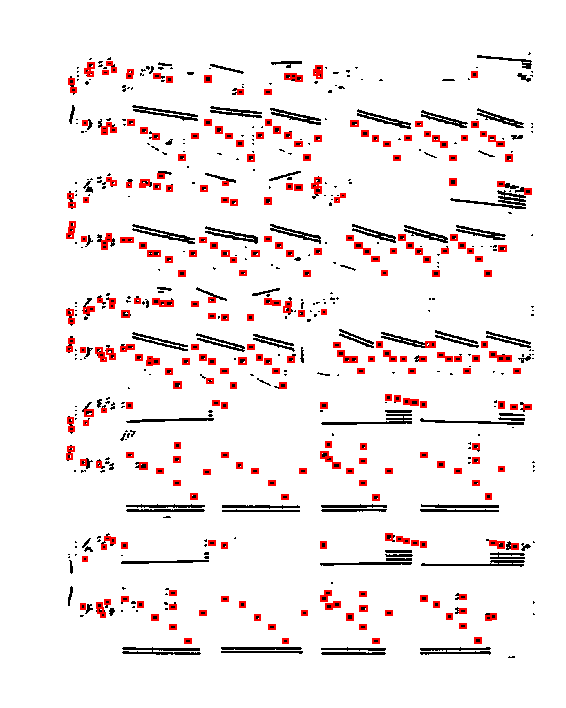

In [250]:
chordBlockSpecs = (chordBlock_minH, chordBlock_maxH, chordBlock_minW, chordBlock_maxW, chordBlock_minArea, chordBlock_maxArea, chordBlock_minNotes, chordBlock_maxNotes)
notes, img_binarized_notes = adaptiveNoteheadDetect(X3, ntemplate, notedetect_tol_ratio, chordBlockSpecs)
#showGrayscaleImage(img_binarized_notes)
visualizeLabels(img_binarized_notes, notes)

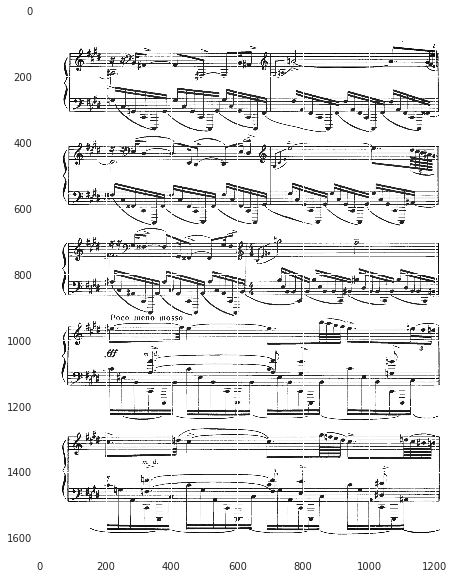

In [251]:
showGrayscaleImage(X2)

In [252]:
def getNoteheadInfo(bboxes):
    nhlocs = [(.5*(bbox[0] + bbox[2]), .5*(bbox[1] + bbox[3])) for bbox in bboxes]
    nhlens = [(bbox[2] - bbox[0]) for bbox in bboxes]
    nhwidths = [(bbox[3] - bbox[1]) for bbox in bboxes]
    nhlen_est = int(np.ceil(np.mean(nhlens)))
    nhwidth_est = int(np.ceil(np.mean(nhwidths)))
    return nhlocs, nhlen_est, nhwidth_est

In [253]:
nhlocs, nhlen_est, nhwidth_est = getNoteheadInfo(notes)
nhlen_est, nhwidth_est

(12, 14)

### Infer Note Values

In [254]:
def getEstStaffLineLocs(featmap, nhlocs, stavelens, colWidth, deltaRowMax, globalOffset = 0):
    preds = []
    if np.isscalar(globalOffset):
        globalOffset = [globalOffset] * len(nhlocs)
    for i, nhloc in enumerate(nhlocs):
        r = int(np.round(nhloc[0]))
        c = int(np.round(nhloc[1]))
        rupper = min(r + deltaRowMax + 1 + globalOffset[i], featmap.shape[1])
        rlower = max(r - deltaRowMax + globalOffset[i], 0)
        featmapIdx = c // colWidth
        regCurrent = np.squeeze(featmap[:, rlower:rupper, featmapIdx])
        mapidx, roffset = np.unravel_index(regCurrent.argmax(), regCurrent.shape)    
        rstart = rlower + roffset
        rend = rstart + stavelens[mapidx] - 1
        preds.append((rstart, rend, c, r, mapidx))
        
    sfiltlen = int(np.round(np.median([stavelens[tup[4]] for tup in preds])))
    return preds, sfiltlen

In [255]:
def visualizeEstStaffLines(preds, arr):
    showGrayscaleImage(arr, (15,15))
    rows1 = np.array([pred[0] for pred in preds]) # top staff line
    rows2 = np.array([pred[1] for pred in preds]) # bottom staff line
    cols = np.array([pred[2] for pred in preds]) # nh col
    rows3 = np.array([pred[3] for pred in preds]) # nh row
    plt.scatter(cols, rows1, c = 'r', s = 3)
    plt.scatter(cols, rows2, c = 'b', s = 3)
    plt.scatter(cols, rows3, c = 'y', s = 3)

(131, 171, 560, 200, 6)


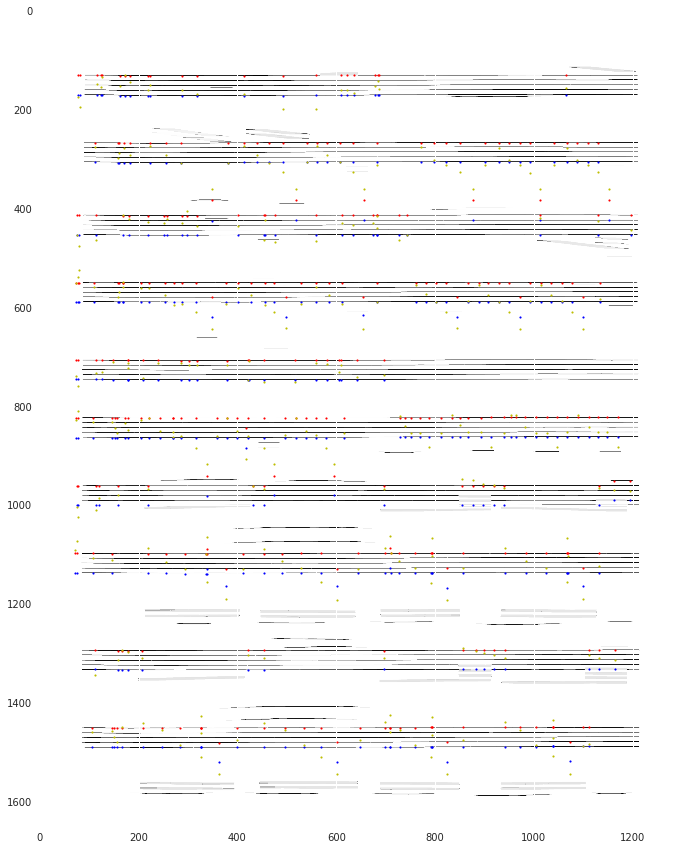

In [256]:
estStaffLineLocs, sfiltlen = getEstStaffLineLocs(featmap, nhlocs, stavelens, columnWidth, maxDeltaRowInitial, int(-2*targetLineSep))
visualizeEstStaffLines(estStaffLineLocs, hlines)
print(estStaffLineLocs[20])

In [257]:
def estimateStaffMidpoints(preds, clustersMin, clustersMax, threshold):
    r = np.array([.5*(tup[0] + tup[1]) for tup in preds]) # midpts of estimated stave locations
    models = []
    for numClusters in range(clustersMin, clustersMax + 1):
        kmeans = KMeans(n_clusters=numClusters, n_init=1, random_state = 0).fit(r.reshape(-1,1))
        sorted_list = np.array(sorted(np.squeeze(kmeans.cluster_centers_)))
        mindiff = np.min(sorted_list[1:] - sorted_list[0:-1])
        if numClusters > clustersMin and mindiff < threshold:
            break
        models.append(kmeans)
    staffMidpts = np.sort(np.squeeze(models[-1].cluster_centers_))
    return staffMidpts

In [258]:
def estimateStaffBoundaries(preds, clustersMin, clustersMax, threshold):
    r = np.array([.5*(tup[0] + tup[1]) for tup in preds]) # midpts of estimated stave locations
    models = []
    for numClusters in range(clustersMin, clustersMax + 1):
        kmeans = KMeans(n_clusters=numClusters, n_init=1, random_state = 0).fit(r.reshape(-1,1))
        sorted_list = np.array(sorted(np.squeeze(kmeans.cluster_centers_)))
        mindiff = np.min(sorted_list[1:] - sorted_list[0:-1])
        if numClusters > clustersMin and mindiff < threshold:
            break
        models.append(kmeans)
    staffMidpts = np.sort(np.squeeze(models[-1].cluster_centers_))
    dist = []
    for staff in staffMidpts:
        dist.append(min([abs(staff - tup[0]) for tup in preds]))
    return staffMidpts, dist

In [259]:
def debugStaffMidpointClustering(preds):
    r = np.array([.5*(tup[0] + tup[1]) for tup in preds]) # midpts of estimated stave locations
    inertias = []
    mindiffs = []
    clusterRange = np.arange(2,12)
    for numClusters in clusterRange:
        kmeans = KMeans(n_clusters=numClusters, n_init=1, random_state = 0).fit(r.reshape(-1,1))
        inertias.append(kmeans.inertia_)
        sorted_list = np.array(sorted(np.squeeze(kmeans.cluster_centers_)))
        diffs = sorted_list[1:] - sorted_list[0:-1]
        mindiffs.append(np.min(diffs))
    plt.subplot(211)
    plt.plot(clusterRange, np.log(inertias))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.subplot(212)
    plt.plot(clusterRange, mindiffs)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Min Centroid Separation')
    plt.axhline(60, color='r')

In [260]:
def visualizeStaffMidpointClustering(preds, centers):
    r = np.array([.5*(tup[0] + tup[1]) for tup in preds]) # midpts of estimated stave locations
    plt.plot(r, np.random.uniform(size = len(r)), '.')
    for center in centers:
        plt.axvline(x=center, color='r')

In [261]:
staveMidpts = estimateStaffMidpoints(estStaffLineLocs, minNumStaves, maxNumStaves, minStaveSeparation)

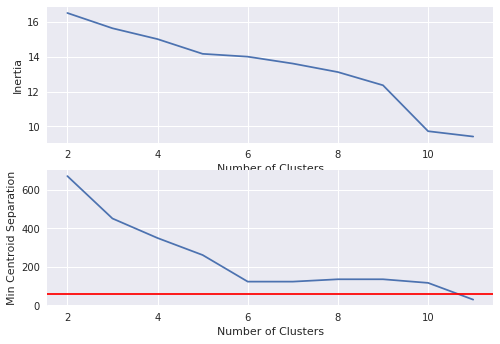

In [262]:
debugStaffMidpointClustering(estStaffLineLocs)

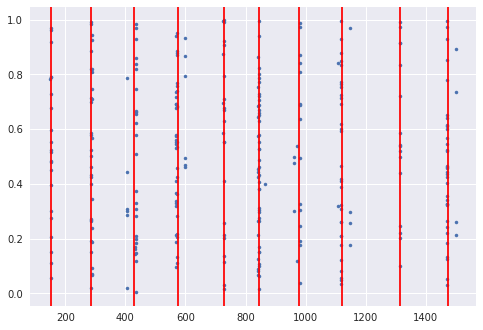

In [263]:
visualizeStaffMidpointClustering(estStaffLineLocs, staveMidpts)

In [264]:
def assignNoteheadsToStaves(nhlocs, staveCenters):
    nhrows = np.matlib.repmat([tup[0] for tup in nhlocs], len(staveCenters), 1)
    centers = np.matlib.repmat(staveCenters.reshape((-1,1)), 1, len(nhlocs))
    staveIdxs = np.argmin(np.abs(nhrows - centers), axis=0)
    offsets = staveCenters[staveIdxs] - nhrows[0,:] # row offset between note and staff midpoint
    return staveIdxs, offsets

In [265]:
def visualizeClusters(arr, nhlocs, clusters):
    showGrayscaleImage(arr)
    rows = np.array([tup[0] for tup in nhlocs])
    cols = np.array([tup[1] for tup in nhlocs])
    plt.scatter(cols, rows, c=clusters)
    for i in range(len(clusters)):
        plt.text(cols[i], rows[i] - 15, str(clusters[i]), fontsize = 12, color='red')

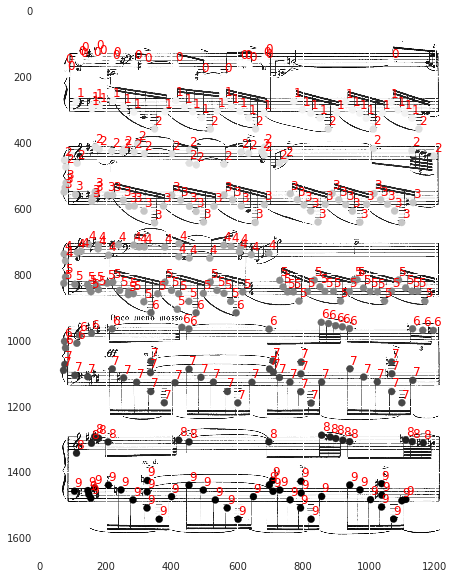

In [266]:
staveIdxs, nhRowOffsets = assignNoteheadsToStaves(nhlocs, staveMidpts)
visualizeClusters(X2, nhlocs, staveIdxs)

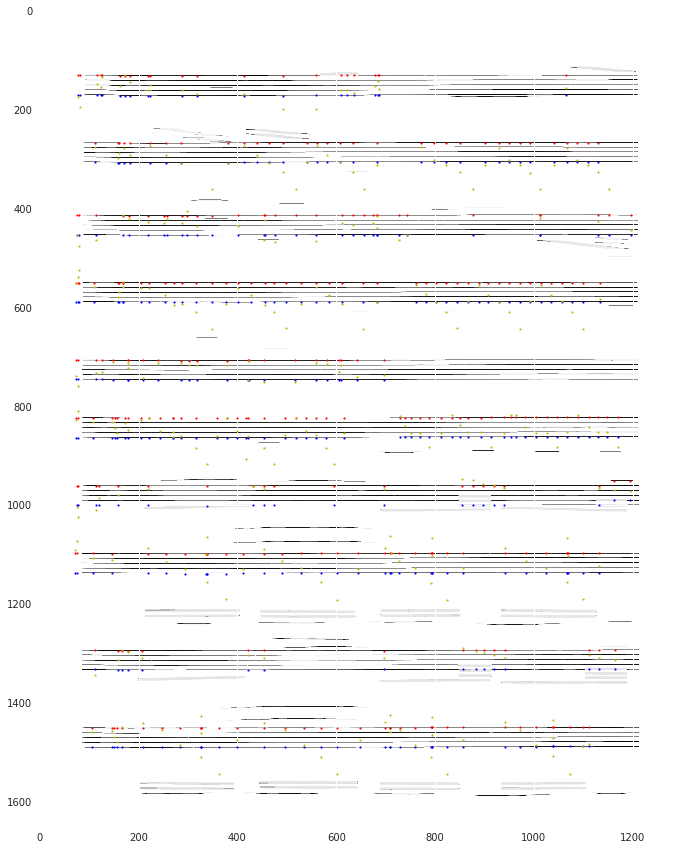

In [267]:
estStaffLineLocs, sfiltlen = getEstStaffLineLocs(featmap, nhlocs, stavelens, columnWidth, maxDeltaRowRefined, (nhRowOffsets - 2*targetLineSep).astype(np.int))
visualizeEstStaffLines(estStaffLineLocs, hlines)

In [268]:
def estimateNoteLabels(preds):
    nhvals = [] # estimated note labels
    for i, (rstart, rend, c, r, filtidx) in enumerate(preds):       
        # if a stave has height L, there are 8 stave locations in (L-1) pixel rows
        staveMidpt = .5 * (rstart + rend)
        noteStaveLoc = -1.0 * (r - staveMidpt) * 8 / (rend - rstart)
        nhval = int(np.round(noteStaveLoc))
        nhvals.append(nhval)
    return nhvals

In [269]:
def visualizeNoteLabels(arr, vals, locs):
    showGrayscaleImage(arr)
    rows = np.array([loc[0] for loc in locs])
    cols = np.array([loc[1] for loc in locs])
    plt.scatter(cols, rows, color='blue')
    for i in range(len(rows)):
        plt.text(cols[i], rows[i] - 15, str(vals[i]), fontsize = 12, color='red')

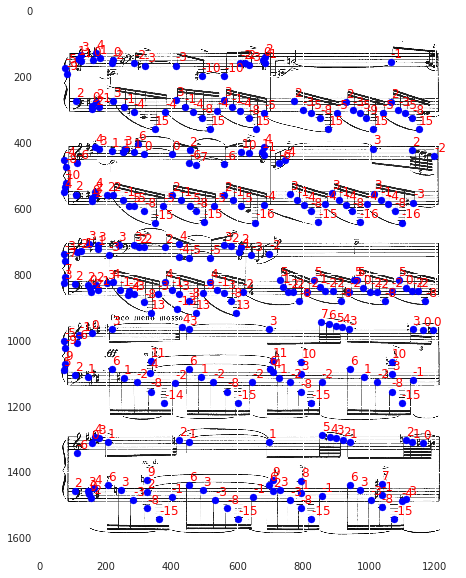

In [270]:
nhvals = estimateNoteLabels(estStaffLineLocs)
visualizeNoteLabels(X2, nhvals, nhlocs)

### Cluster staves & noteheads

In [271]:
def isolateBarlines(im, morphFilterVertLineLength, morphFilterVertLineWidth, maxBarlineWidth):
    hkernel = np.ones((1, morphFilterVertLineWidth), np.uint8) # dilate first to catch warped barlines
    vlines = cv2.dilate(im, hkernel, iterations = 1)
    vlines = morphFilterRectangle(vlines, morphFilterVertLineLength, 1) # then filter for tall vertical lines
    nonbarlines = morphFilterRectangle(vlines, 1, maxBarlineWidth)
    vlines = np.clip(vlines - nonbarlines, 0, 1)
    return vlines

(1650, 1275)

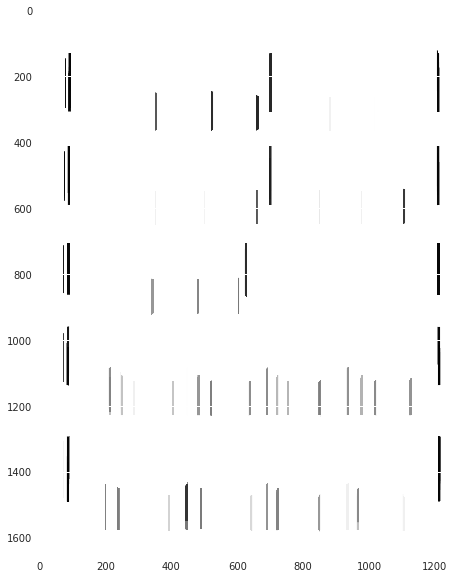

In [272]:
vlines = isolateBarlines(X2, morphFilterVertLineLength, morphFilterVertLineWidth, maxBarlineWidth)
showGrayscaleImage(vlines)
vlines.shape

In [273]:
def determineStaveGrouping(staveMidpts, vlines):
    
    N = len(staveMidpts)
    rowSums = np.sum(vlines, axis=1)
    
    # grouping A: 0-1, 2-3, 4-5, ...
    elems_A = []
    map_A = {}
    for i, staveIdx in enumerate(np.arange(0, N, 2)):
        if staveIdx+1 < N:
            startRow = int(staveMidpts[staveIdx])
            endRow = int(staveMidpts[staveIdx+1]) + 1
            elems_A.extend(rowSums[startRow:endRow])
            map_A[staveIdx] = staveIdx
            map_A[staveIdx+1] = staveIdx + 1
        else:
            map_A[staveIdx] = -1 # unpaired stave
    
    # grouping B: 1-2, 3-4, 5-6, ...
    elems_B = []
    map_B = {}
    map_B[0] = -1 
    for i, staveIdx in enumerate(np.arange(1, N, 2)):
        if staveIdx+1 < N:
            startRow = int(staveMidpts[staveIdx])
            endRow = int(staveMidpts[staveIdx+1]) + 1
            elems_B.extend(rowSums[startRow:endRow])
            map_B[staveIdx] = staveIdx - 1
            map_B[staveIdx + 1] = staveIdx
        else:
            map_B[staveIdx] = -1
    
    if N > 2:
        evidence_A = np.median(elems_A)
        evidence_B = np.median(elems_B)
        if evidence_A > evidence_B:
            mapping = map_A
        else:
            mapping = map_B
    else:
        evidence_A = np.median(elems_A)
        evidence_B = 0
        mapping = map_A
    
    return mapping, (evidence_A, evidence_B, elems_A, elems_B)

In [274]:
staveMapping, evidence = determineStaveGrouping(staveMidpts, vlines)
np.median(evidence[2]), np.median(evidence[3])

(23.337254901960783, 10.345098039215685)

In [275]:
def debugStaveGrouping(vlines, staveCenters):
    plt.plot(np.sum(vlines, axis=1))
    for m in staveCenters:
        plt.axvline(m, color = 'r')

In [276]:
staveMapping

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

In [277]:
staveMidpts

array([ 151.38636364,  287.16666667,  428.46875   ,  574.1       ,
        727.        ,  844.01960784,  976.975     , 1120.79166667,
       1313.75      , 1473.56578947])

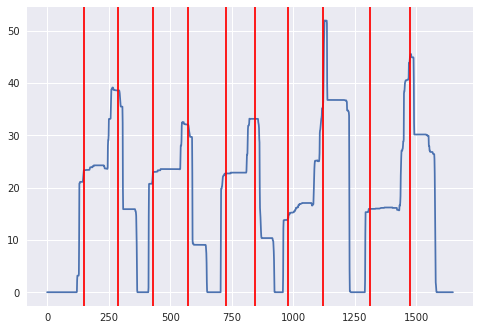

In [278]:
debugStaveGrouping(vlines, staveMidpts)

In [279]:
def clusterNoteheads(staveIdxs, mapping):
    clusterIdxs = [mapping[staveIdx] for staveIdx in staveIdxs]
    maxClusterIdx = np.max(np.array(clusterIdxs))
    clusterPairs = []
    for i in range(0, maxClusterIdx, 2):
        clusterPairs.append((i,i+1))
    return clusterIdxs, clusterPairs

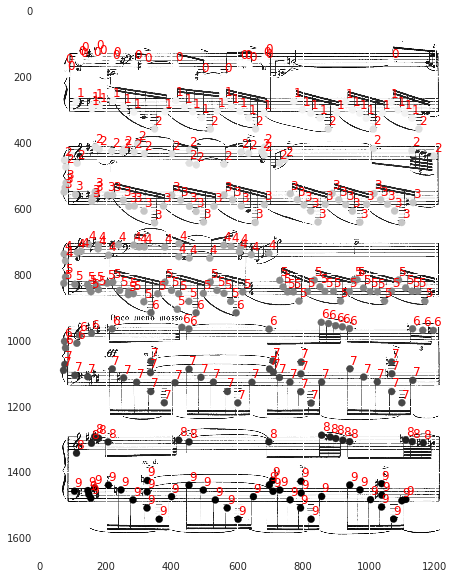

In [280]:
nhclusters, clusterPairs = clusterNoteheads(staveIdxs, staveMapping)
visualizeClusters(X2, nhlocs, nhclusters)

### Generate Bootleg Score

In [281]:
def generateSingleBootlegLine(nhdata, clusterR, clusterL, minColDiff, repeatNotes = 1, filler = 0):
    notes = [tup for tup in nhdata if tup[3] == clusterR or tup[3] == clusterL]
    notes = sorted(notes, key = lambda tup: (tup[1], tup[0])) # sort by column, then row
    collapsed = collapseSimultaneousEvents(notes, minColDiff) # list of (rows, cols, vals, clusters)
    bscore, eventIndices, staffLinesBoth, _, _ = constructBootlegScore(collapsed, clusterR, clusterL, repeatNotes, filler)
    return bscore, collapsed, eventIndices, staffLinesBoth

In [282]:
def collapseSimultaneousEvents(notes, minColDiff):
    assigned = np.zeros(len(notes), dtype=bool)
    events = [] # list of simultaneous note events
    for i, (row, col, val, cluster) in enumerate(notes):
        if assigned[i]: # has already been assigned
            continue
        rows = [row] # new event
        cols = [col]
        vals = [val]
        clusters = [cluster]
        assigned[i] = True
        for j in range(i+1, len(notes)):
            nrow, ncol, nval, ncluster = notes[j]
            if ncol - col < minColDiff: # assign to same event if close
                rows.append(nrow)
                cols.append(ncol)
                vals.append(nval)
                clusters.append(ncluster)
                assigned[j] = True
            else:
                break
        events.append((rows, cols, vals, clusters))
    
    assert(np.all(assigned))
    return events

In [283]:
def constructBootlegScore(noteEvents, clusterIndexRH, clusterIndexLH, repeatNotes = 1, filler = 0):
    # note that this has to match generateBootlegScore() in the previous notebook!
    rh_dim = 34 # E3 to C8 (inclusive)
    lh_dim = 28 # A1 to G4 (inclusive)
    rh = [] # list of arrays of size rh_dim
    lh = [] # list of arrays of size lh_dim
    eventIndices = [] # index of corresponding simultaneous note event
    for i, (rows, cols, vals, clusters) in enumerate(noteEvents):

        # insert note events columns
        rhvec, lhvec = getNoteheadPlacement(vals, clusters, rh_dim, lh_dim, clusterIndexRH, clusterIndexLH)
        rh.append(rhvec)
        lh.append(lhvec)
        eventIndices.append(i)
    rh = np.squeeze(np.array(rh)).reshape((-1, rh_dim)).T # reshape handles case when len(rh) == 1
    lh = np.squeeze(np.array(lh)).reshape((-1, lh_dim)).T
    both = np.vstack((lh, rh))
    staffLinesRH = [7,9,11,13,15]
    staffLinesLH = [13,15,17,19,21]
    staffLinesBoth = [13,15,17,19,21,35,37,39,41,43]
    return both, eventIndices, staffLinesBoth, (rh, staffLinesRH), (lh, staffLinesLH)

In [284]:
def getNoteheadPlacement(vals, clusters, rdim, ldim, clusterRH, clusterLH):
    rhvec = np.zeros((rdim, 1))
    lhvec = np.zeros((ldim, 1))
    assert(clusterLH == clusterRH + 1)
    for (val, cluster) in zip(vals, clusters):
        if cluster == clusterRH:
            idx = val + 11
            if idx >= 0 and idx < rdim:
                rhvec[idx, 0] = 1
        elif cluster == clusterLH:
            idx = val + 17
            if idx >= 0 and idx < ldim:
                lhvec[idx, 0] = 1
        else:
            print("Invalid cluster: {} (LH {}, RH {})".format(cluster, clusterLH, clusterRH))
            sys.exit(1)
    return rhvec, lhvec

In [285]:
def visualizeBootlegScore(bs, lines):
    plt.figure(figsize = (10,10))
    plt.imshow(1 - bs, cmap = 'gray', origin = 'lower')
    for l in range(1, bs.shape[0], 2):
        plt.axhline(l, c = 'grey')
    for l in lines:
        plt.axhline(l, c = 'r')

In [286]:
# list of (row, col, value, cluster) tuples
nhdata = [(int(np.round(nhlocs[i][0])), int(np.round(nhlocs[i][1])), nhvals[i], nhclusters[i]) for i in range(len(nhlocs))]

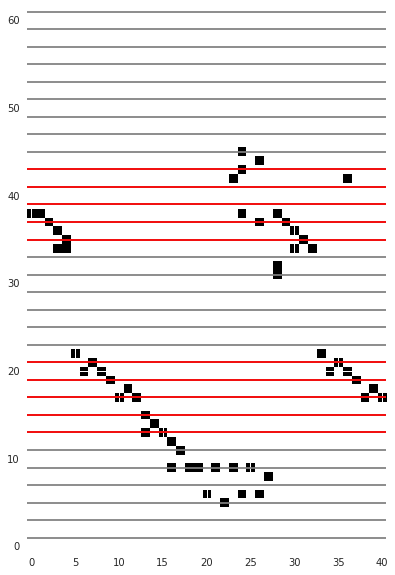

In [76]:
bscore, events, eventIndices, staffLinesBoth = generateSingleBootlegLine(nhdata, clusterR = 0, clusterL = 1, minColDiff = nhwidth_est, repeatNotes = 1, filler = 0)
visualizeBootlegScore(bscore, staffLinesBoth)

In [77]:
def generateQueryBootlegScore(nhdata, pairings, repeatNotes = 1, filler = 0, minColDiff = 10):
    allScores = []
    allEvents = []
    globIndices = []
    eventCount = 0
    for i, (clusterR, clusterL) in enumerate(pairings):
        score, events, eventIndices, staffLinesBoth = generateSingleBootlegLine(nhdata, clusterR, clusterL, minColDiff, repeatNotes, filler)
        allScores.append(score)
        allEvents.extend(events)
        globIndices.extend([idx + eventCount for idx in eventIndices])
        if i < len(pairings) - 1:
            allScores.append(np.zeros((score.shape[0], filler))) # append filler columns between bootleg scores
        eventCount += len(events)
    panorama = np.hstack(allScores)
    return panorama, allEvents, globIndices, staffLinesBoth

In [78]:
def visualizeLongBootlegScore(bs, lines, chunksz = 150):
    chunks = bs.shape[1] // chunksz + 1
    for i in range(chunks):
        startcol = i * chunksz
        endcol = min((i + 1)*chunksz, bs.shape[1])
        visualizeBootlegScore(bs[:,startcol:endcol], lines)

In [287]:
def generatePageQueryBootlegScore(imagefile):
    # pre-processing
    pim1 = Image.open(imagefile).convert('L') # pim indicates PIL image object, im indicates raw pixel values
    #pim1 = pim1.resize([resizeW, resizeH])
    pim2 = removeBkgdLighting(pim1, thumbnailFilterSize, thumbnailW, thumbnailH)
    linesep, scores = estimateLineSep(pim2, estLineSep_NumCols, estLineSep_LowerRange, estLineSep_UpperRange, estLineSep_Delta)
    targetH, targetW = calcResizedDimensions(pim2, linesep, targetLineSep)
    pim2 = pim2.resize((targetW, targetH))
    resize_dim = (pim1.height / targetH, pim1.width / targetW)

    # staff line features
    X2 = getNormImage(pim2)
    hlines = isolateStaffLines(X2, morphFilterHorizLineSize, notebarFiltLen, notebarRemoval)
    featmap, stavelens, columnWidth = computeStaveFeatureMap(hlines, calcStaveFeatureMap_NumCols, calcStaveFeatureMap_LowerRange, calcStaveFeatureMap_UpperRange, calcStaveFeatureMap_Delta)
    
    # notehead detection
    im3 = morphFilterCircle(pim2, morphFilterCircleSizeReduce, morphFilterCircleSizeExpand)
    keypoints, im_with_keypoints = detectNoteheadBlobs(im3, notedetect_minarea, notedetect_maxarea)
    X3 = getNormImage(im3) # im indicates grayscale [0, 255], X indicates [0, 1] inverted grayscale
    if not np.any(X3): # empty image
        return (np.empty((62,0)),[])
    ntemplate, numCrops = getNoteTemplate(X3, keypoints, noteTemplateSize)
    chordBlockSpecs = (chordBlock_minH, chordBlock_maxH, chordBlock_minW, chordBlock_maxW, chordBlock_minArea, chordBlock_maxArea, chordBlock_minNotes, chordBlock_maxNotes)
    notes, img_binarized_notes = adaptiveNoteheadDetect(X3, ntemplate, notedetect_tol_ratio, chordBlockSpecs)
    if len(notes) < maxNumStaves: # if few or no notes detected, stop early (avoids later errors during kmeans clustering)
        #saveToFile(outfile, imagefile, (0, 0), time.time() - profileStart)
        return (np.empty((62,0)),[])
    nhlocs, nhlen_est, nhwidth_est = getNoteheadInfo(notes)
    
    # infer note values
    estStaffLineLocs, sfiltlen = getEstStaffLineLocs(featmap, nhlocs, stavelens, columnWidth, maxDeltaRowInitial, int(-2*targetLineSep))
    
    # decide upper and lower stave location
    staveMidpts, dist = estimateStaffBoundaries(estStaffLineLocs, minNumStaves, maxNumStaves, minStaveSeparation)
    staveIdxs, nhRowOffsets = assignNoteheadsToStaves(nhlocs, staveMidpts)
    estStaffLineLocs, sfiltlen = getEstStaffLineLocs(featmap, nhlocs, stavelens, columnWidth, maxDeltaRowRefined, (nhRowOffsets - 2*targetLineSep).astype(np.int))    
    nhvals = estimateNoteLabels(estStaffLineLocs)
    
    # cluster noteheads & staves
    vlines = isolateBarlines(X2, morphFilterVertLineLength, morphFilterVertLineWidth, maxBarlineWidth)
    staveMapping, evidence = determineStaveGrouping(staveMidpts, vlines)
    nhclusters, clusterPairs = clusterNoteheads(staveIdxs, staveMapping)
    
    # generate & align bootleg scores
    nhdata = [(int(np.round(nhlocs[i][0])), int(np.round(nhlocs[i][1])), nhvals[i], nhclusters[i]) for i in range(len(nhlocs))]
    bscore_query, events, eventIndices, staffLinesBoth = generateQueryBootlegScore(nhdata, clusterPairs, bootlegRepeatNotes, bootlegFiller, minColDiff = nhwidth_est)

    staveCorrected = []
    rightHandStaff = True
    for staffIdx in range(len(staveMidpts)):
        if staveMapping[staffIdx] != -1:
            if rightHandStaff:
                staveCorrected.append(staveMidpts[staffIdx] - dist[staffIdx])
                rightHandStaff = False
            else:
                staveCorrected.append(staveMidpts[staffIdx] + dist[staffIdx])
                rightHandStaff = True
    # update events matrix with staff location info
    
    for i, event in enumerate(events):
        if event[3][0] % 2 == 0:
            events[i] = list(events[i]) + (staveCorrected[event[3][0]:event[3][0] + 2])
        else:
            events[i] = list(events[i]) + (staveCorrected[event[3][0] - 1:event[3][0] + 1])
    
    #[[285, 216], [117, 119], 0, 179.7567567567569, 292.8333333333335]
    for i, event in enumerate(events):
        events[i][3] = math.floor(events[i][3][0] / 2)
        events[i] = events[i][0:2] + events[i][3:]
        events[i][0]=list(map(lambda num:num*resize_dim[0],events[i][0]))
        events[i][1]=list(map(lambda num:num*resize_dim[1],events[i][1]))
        if len(events[i]) == 3:
            events[i].append(events[i-1][-1])
        else:
            events[i][3] *= resize_dim[0]
        if len(events[i]) == 4:
            events[i].append(events[i-1][-1])
        else:
            events[i][4] *= resize_dim[0]
        
    return bscore_query, events

In [80]:
bscore_query, events = generatePageQueryBootlegScore(imagefile)

In [83]:
def takeNum(file):
    return int((file.split('-')[1]).split('.')[0])

def sortFile(piece_dir):
    filelist = glob.glob(piece_dir + '/*.png')
    return sorted(filelist, key=takeNum)

In [288]:
def generatePieceBootlegScore(piece_dir):
    
    images = sortFile(piece_dir)
    bscore_query = np.empty([62, 1])
    events = []
    for image in images:
        page_bscore_query, page_events = generatePageQueryBootlegScore(image)
        page_bscore_query = np.asarray(page_bscore_query)
        bscore_query = np.hstack((bscore_query, page_bscore_query))
        events += page_events
    
    # update events matrix with page info
    page = 0
    for i, event in enumerate(events):
        if i == 0:
            events[i].append(1)
        elif event[2] <= 1 and events[i-1][2] > 1:
            events[i].append(events[i-1][-1] + 1)
        else:
            events[i].append(events[i-1][-1])
            
    bscore_query = bscore_query[:,1:]
    return bscore_query, events

In [ ]:
bscore_sheet, events = generatePieceBootlegScore('/home/mshan/ttemp/data/png/p{}'.format(20))

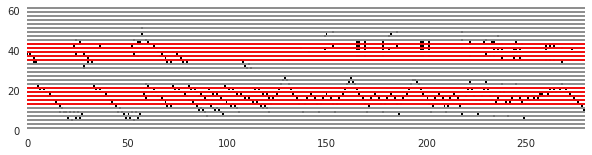

In [85]:
visualizeLongBootlegScore(bscore_query, staffLinesBoth, chunksz = 300)

### Generate sheet bscore for all pieces

In [295]:
import time
for i in [99, 109, 117, 120, 139, 172, 179, 186]:
    if str(i)[-1] not in ['1','5']:
        print("Processing Piece {}".format(i))
        start = time.time()
        bscore_sheet, events = generatePieceBootlegScore('/home/mshan/ttemp/data/png/p{}'.format(i))
        d = {'bscore': bscore_sheet, 'events': events, 'time': time.time() - start}
        with open('/home/mshan/ttemp/data/bscore_sheet/p{}.pkl'.format(i), 'wb') as f:
            pickle.dump(d, f)

Processing Piece 99
Processing Piece 109
Processing Piece 117
Processing Piece 120
Processing Piece 139
Processing Piece 172


/home/mshan/py3env/lib/python3.5/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Processing Piece 179
Processing Piece 186


In [219]:
# sheet_bscore_test_time
time = 0
count = 0
for i in range(1, 201):
    if str(i)[-1] not in ['1', '5']:
        with open('/home/mshan/ttemp/data/bscore_sheet/p{}.pkl'.format(i), 'rb') as p:
            d = pickle.load(p)
            time += d['time']
            count += 1
print(time/count)

37.326178076863286
